# 사과 종 분류 과제

## 데이터 구조

```
$ DATA/
├── train/
│   ├── xxx.jpg
│   ├── yyy.jpg
│   └── zzz.jpg
├── test/
│   ├── xxx.jpg
│   ├── yyy.jpg
│   └── zzz.jpg
├── train.csv
├── test.csv
├── sample_submission.csv
├── train_labels.csv (코드 실행 후 생성)
└── valid_labels.csv (코드 실행 후 생성)
```



## 0. 사전 준비

### 구글 드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



### 데이터 압축 풀기

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/apple/data')

In [ ]:
!unzip train.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train/bFSIYcahj3.jpg    
  inflating: train/9U3S6jj4er.jpg    
  inflating: train/pnKuZ0FzkB.jpg    
  inflating: train/Qoc5TX65n7.jpg    
  inflating: train/082hfn8vYV.jpg    
  inflating: train/hs4wG5jrtt.jpg    
  inflating: train/7TTvlqrCiE.jpg    
  inflating: train/BJdKoXByLq.jpg    
  inflating: train/S3uBSCuWSk.jpg    
  inflating: train/HZqhndLORM.jpg    
  inflating: train/bd0GFtAyAe.jpg    
  inflating: train/pGKZAFvGVb.jpg    
  inflating: train/wW3f9kUSFd.jpg    
  inflating: train/Vke0xHv9EZ.jpg    
  inflating: train/A9MT6kvNah.jpg    
  inflating: train/Qs40p2I1om.jpg    
  inflating: train/2zFAAwfbX4.jpg    
  inflating: train/Zgnf8Y9Kyg.jpg    
  inflating: train/kRX3PZIyTS.jpg    
  inflating: train/2GpycQSdF2.jpg    
  inflating: train/rrPBFVNKl2.jpg    
  inflating: train/EUrM7hyWc7.jpg    
  inflating: train/fxBO5gVlDY.jpg    
  inflating: train/1ePnzogzpw.jpg    
  inflating: train/EM4JHOyORC.jpg    
  inflating: t

In [ ]:
!unzip test.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: test/PIzNa2WiXw.jpg     
  inflating: test/WnFTa6fw0Q.jpg     
  inflating: test/hl1h42CPoC.jpg     
  inflating: test/IFmhkZEVKr.jpg     
  inflating: test/CTipO691Fj.jpg     
  inflating: test/iJTnpRyfZM.jpg     
  inflating: test/zKSDPDVKsO.jpg     
  inflating: test/66n7pgadWJ.jpg     
  inflating: test/qZKAI5H4xF.jpg     
  inflating: test/Loz8UAINqW.jpg     
  inflating: test/XHNMO54eZW.jpg     
  inflating: test/UbqJJHHCU2.jpg     
  inflating: test/DmMkjW2SF0.jpg     
  inflating: test/7K1Od04Dse.jpg     
  inflating: test/bIFJDHNK27.jpg     
  inflating: test/BPpGRE0nyN.jpg     
  inflating: test/61KQg8ss82.jpg     
  inflating: test/fNzTf85Ubw.jpg     
  inflating: test/A2il0D4T8p.jpg     
  inflating: test/kwmYxDrB4F.jpg     
  inflating: test/KwByXzDZ2p.jpg     
  inflating: test/icbrK5EDKt.jpg     
  inflating: test/LZvBUor4Nz.jpg     
  inflating: test/zbW7W5bupd.jpg     
  inflating: test/LJjZSgbVcK.jpg     
  inflating: t

### 필요 라이브러리 설치

In [ ]:
!pip install timm
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 6.6 MB/s 
     |████████████████████████████████| 182 kB 27.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1. 라이브러리 불러오기

In [ ]:
from torch.utils.data import DataLoader
import torch

from datetime import datetime, timezone, timedelta
import numpy as np
import random
import os
import copy

import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random

import timm
from torch import nn

from sklearn.metrics import accuracy_score, f1_score

## 2. 경로 / 기타 인자 설정

### 데이터 경로 설정

In [ ]:
# 프로젝트 경로
PROJECT_DIR = '/content/drive/MyDrive/Colab Notebooks/apple'
os.chdir(PROJECT_DIR)

# 데이터 경로
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
TRAIN_IMG_DIR = os.path.join(DATA_DIR, 'train')
TRAIN_LABEL_DIR = os.path.join(DATA_DIR, 'train.csv')
TEST_IMG_DIR = os.path.join(DATA_DIR, 'test')
TEST_LABEL_DIR = os.path.join(DATA_DIR, 'test.csv')
SAMPLE_DIR = os.path.join(DATA_DIR, 'sample_submission.csv')

In [ ]:
# 파일 수 확인 
print(len(os.listdir(TRAIN_IMG_DIR)))
print(len(os.listdir(TEST_IMG_DIR)))

10000
5000


### 결과 저장 경로 설정

In [ ]:
# 시간 고유값 
kst = timezone(timedelta(hours=9))        
train_serial = datetime.now(tz=kst).strftime("%Y%m%d_%H%M%S")

# 기록 경로
RECORDER_DIR = os.path.join(PROJECT_DIR, 'results', 'train', train_serial)
# 현재 시간 기준 폴더 생성
os.makedirs(RECORDER_DIR, exist_ok=True)    

### 시드 설정

In [ ]:
# 시드
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

### 디바이스 설정

In [ ]:
# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 3. 데이터 불러오기 및 분할

### Train 라벨

In [ ]:
# 학습 파일
traindf = pd.read_csv(TRAIN_LABEL_DIR)

traindf.head()

,img_id,a_type
0,yVvIyEOqz8.jpg,HJ
1,HLdFN3ULg2.jpg,HJ
2,bAm1CUZtO8.jpg,HJ
3,n5hMUvCCV6.jpg,HR
4,9RiwdmWGSq.jpg,SG


### Train 이미지 예시

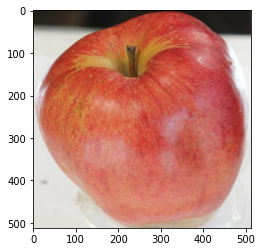

In [ ]:
# 이미지 예시
example_index = random.randrange(len(traindf)) # 0,1,2,...
example_imageid = traindf['img_id'][example_index]
example_image_path = os.path.join(TRAIN_IMG_DIR, example_imageid)
example_image = Image.open(example_image_path)

plt.imshow(example_image)

### Train / Validation 분할

In [ ]:
# 80% / 20% 비율로 분할
train,val = train_test_split(traindf, test_size=0.2, shuffle=True)

# train / validation로 나눈 데이터 프레임 저장
train.to_csv(os.path.join(DATA_DIR, 'train_labels.csv'), index=False)
val.to_csv(os.path.join(DATA_DIR, 'val_labels.csv'),index=False)

## 4. Dataset 

### Dataset 클래스 정의

In [ ]:
class AppleDataset(Dataset):
  def __init__(self, img_folder, labelpath):
    self.df = pd.read_csv(labelpath, usecols=['img_id','a_type'],dtype={'a_ty pe':str})
    self.label_encoding = {'HJ':0, 'HR':1, 'SG':2, 'AR':3}
    self.img_folder = img_folder
    self.transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])  
    self.img_ids = list(self.df['img_id'])
    self.labels = list(self.df['a_type'])
  
  def __len__(self):
    return len(self.img_ids)

  def __getitem__(self, index):
    impath = os.path.join(self.img_folder, self.img_ids[index])
    img = Image.open(impath)
    img = self.transforms(img)
    lbl = self.labels[index]
    lbl = self.label_encoding[lbl]
    return img,lbl


## 5. 모델 정의

### 모델 Class 생성

In [ ]:
F = nn.functional

class CustomNet(nn.Module):
  def __init__(self):
    super(CustomNet, self).__init__()
    # 합성곱 층
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)
    self.pool1 = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,3,3,4)
    self.pool2 = nn.MaxPool2d(2,2)
    self.conv3 = nn.Conv2d(3,3,3,padding=1)

    # 완전 연결 층
    self.fc1 = nn.Linear(3072, 1036)
    self.fc2 = nn.Linear(1036, 518)
    self.fc3 = nn.Linear(518, 4)

  def forward(self, x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = F.relu(self.conv3(x))
    x = torch.flatten(x, 1) 
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    output = self.fc3(x)   
    return output
  
class EffNet(nn.Module):
  def __init__(self):
    super(EffNet, self).__init__()
    self.model = timm.create_model('efficientnet_b4', pretrained=True)
    self.model.classifier = nn.Sequential(
        nn.Linear(in_features = 1792, out_features = 625),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(625,256),
        nn.ReLU(),
        nn.Linear(256, 4)
    )
    for param in self.model.parameters():
      param.requires_grad = False
    for param in self.model.classifier.parameters():
      param.requires_grad = True
  
  def forward(self, x):
    output = self.model(x)
    return output

### 모델 선택 함수

In [ ]:
def get_model(model_name:str):
  if model_name == 'Custom':
    return CustomNet()
  if model_name == 'effnet':
    return EffNet()

## 6. 학습

### DataLoader 관련 인자 설정

In [ ]:
# Dataloader 관련 인자
BATCH_SIZE = 16
NUM_WORKERS = 1
SHUFFLE = True
PIN_MEMORY = True
DROP_LAST = False

### Dataset 및 DataLoader 생성



In [ ]:
# 데이터 셋 정의
train_dataset = AppleDataset(img_folder = TRAIN_IMG_DIR, labelpath = os.path.join(DATA_DIR,'train_labels.csv'))
valid_dataset = AppleDataset(img_folder = TRAIN_IMG_DIR, labelpath = os.path.join(DATA_DIR,'val_labels.csv'))

# 데이터 로더 정의
train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              num_workers = NUM_WORKERS,
                              shuffle = SHUFFLE,
                              pin_memory = PIN_MEMORY,
                              drop_last = DROP_LAST)

valid_dataloader = DataLoader(dataset = valid_dataset,
                              batch_size = BATCH_SIZE,
                              num_workers = NUM_WORKERS,
                              shuffle = SHUFFLE,
                              pin_memory = PIN_MEMORY,
                              drop_last = DROP_LAST)

### 모델 설정

In [ ]:
# Hyperparameter 설정
LEARNING_RATE = 5e-5
EPOCHS = 2

In [ ]:
# 모델 불러오기
model = get_model('Custom')
model.to(device)

# Loss와 optimizer 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

### 학습 진행

In [ ]:
best_loss = np.Inf

for epoch in range(EPOCHS):
  ### 학습 ###
  model.train()  # 모델 학습 적용
  
  train_total_loss = 0
  target_list = [] # 실제 사과 종 추가할 리스트 
  pred_list = []  # 예측 사과 종 추가할 리스트
  
  # train
  for batch_index, (x,y) in tqdm(enumerate(train_dataloader)):
    x,y = x.to(device), y.to(device)                          # x - image data, y - 실제 label을 GPU로 옮김 
    y_pred = model(x)                                         # 모델을 통해 나온 output
    loss = criterion(y_pred, y)                               # 실제값 y와 예측값 y_pred로 loss 계산
    optimizer.zero_grad()                                     # optimizer 초기화
    loss.backward()                                           # gradient 계산
    optimizer.step()                                          # 역전파
    train_total_loss += loss.item()                           # train_total_loss에 loss값을 누적
    pred_list.extend(y_pred.argmax(dim=1).cpu().tolist())     # 예측한 값중 가장 높은 값의 인덱스를 추가
    target_list.extend(y.cpu().tolist())                      # 실제 label 인덱스를 추가 
  train_mean_loss = train_total_loss / batch_index            # 에폭의 평균 loss
  train_accuracy = accuracy_score(target_list, pred_list)     # accuracy_score
  train_f1score = f1_score(target_list, pred_list, average='macro')  # macro - f1 Score
  
  ### 검증 ###
  model.eval()                                                # 학습 모드를 검증 모드로 변경
  val_total_loss = 0                                          
  target_list = []                                            
  pred_list = []
  with torch.no_grad():                                       # 역전파 하지 않음
    for batch_index, (x,y) in tqdm(enumerate(valid_dataloader)):    
      x = x.to(device)                                         
      y = y.to(device)
      y_pred = model(x)
      loss = criterion(y_pred, y)
      #
      val_total_loss += loss.item()
      target_list.extend(y.cpu().tolist())
      pred_list.extend(y_pred.argmax(dim=1).cpu().tolist())
  val_mean_loss = val_total_loss / batch_index
  val_accuracy = accuracy_score(target_list, pred_list)
  val_f1score = f1_score(target_list, pred_list, average='macro')

  msg1 = f"Epoch {epoch}/{EPOCHS} - Train loss: {train_mean_loss}; Train Accuracy: {train_accuracy}; Train F1: {train_f1score}"
  msg2 = f"Valid loss: {val_mean_loss}; Val Accuracy: {val_accuracy}; Val F1: {val_f1score}"
  print(msg1)
  print(msg2)

  ### 결과 저장 ###
  # validation loss가 개선될 때 모델 저장
  if val_mean_loss < best_loss:                               
    best_loss = val_mean_loss
    check_point = {                                         
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(check_point, os.path.join(RECORDER_DIR,'best.pt')) 


500it [01:42,  4.89it/s]
125it [00:23,  5.34it/s]


Epoch 0/2 - Train loss: 1.0961015139648576; Train Accuracy: 0.545125; Train F1: 0.20802045353679277
Valid loss: 0.9722108100691149; Val Accuracy: 0.624; Val F1: 0.3136052732314414


500it [01:36,  5.18it/s]
125it [00:23,  5.27it/s]


Epoch 1/2 - Train loss: 0.7447483751900449; Train Accuracy: 0.732375; Train F1: 0.4739336248633984
Valid loss: 0.5681414875772691; Val Accuracy: 0.8015; Val F1: 0.5998521279223142


## 7. 추론

### 데이터 셋 설정

In [ ]:
class TestDataset(Dataset):
  def __init__(self, img_folder, labelpath):
    self.df = pd.read_csv(labelpath , usecols=['img_id'],dtype={'img_id':str})
    self.img_folder = img_folder
    self.transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
    self.img_ids = list(self.df['img_id'])
      
  def __len__(self):
    return len(self.img_ids)
  
  def __getitem__(self, index):
    impath = os.path.join(self.img_folder, self.img_ids[index])
    img = Image.open(impath)
    img = self.transforms(img)
    img_ids = self.img_ids[index]
    
    return img,img_ids

#### 모델설정

In [ ]:
# 모델 Load
model = get_model('Custom')
checkpoint = torch.load(os.path.join(RECORDER_DIR, 'best.pt'))
model.load_state_dict(checkpoint['model'])
model.to(device)

CustomNet(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 3, kernel_size=(3, 3), stride=(4, 4))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3072, out_features=1036, bias=True)
  (fc2): Linear(in_features=1036, out_features=518, bias=True)
  (fc3): Linear(in_features=518, out_features=4, bias=True)
)

### Dataset 및 DataLoader 설정

In [ ]:
# Dataloader 관련 인자
BATCH_SIZE = 1
NUM_WORKERS = 1
SHUFFLE = False
PIN_MEMORY = True
DROP_LAST = False

In [ ]:
# Dataset
test_dataset = TestDataset(img_folder = TEST_IMG_DIR, labelpath = os.path.join(TEST_LABEL_DIR))


# DataLoader
test_dataloader = DataLoader(dataset = test_dataset,
                              batch_size = BATCH_SIZE,
                              num_workers = NUM_WORKERS,
                              shuffle = SHUFFLE,
                              pin_memory = PIN_MEMORY,
                              drop_last = DROP_LAST)

### 추론 진행

In [ ]:
model.eval()      # 학습 모드를 검증 모드로 변경

# 예측 진행
y_preds = []
img_ids = []

for batch_index, (x, img_id) in enumerate(tqdm(test_dataloader)):
    x = x.to(device, dtype=torch.float)
    y_logits = model(x).cpu()
    y_pred = torch.argmax(y_logits, dim=1)
    y_pred = y_pred.cpu().tolist()
    img_ids.extend(img_id)
    y_preds.extend(y_pred)

100%|██████████| 5000/5000 [01:05<00:00, 76.25it/s]


### 추론 결과 저장

In [ ]:
# 결과 데이터 프레임 생성 및 라벨 디코딩
pred_df = pd.DataFrame(list(zip(img_ids, y_preds)), columns=['img_id','a_type'])
label_decoding = {0:'HJ', 1:'HR', 2:'SG', 3:'AR'}
pred_df['a_type'] = pred_df['a_type'].replace(label_decoding)

In [ ]:
# 샘플과 동일한 순서로 변경
sample_df = pd.read_csv(SAMPLE_DIR)
sorter = list(sample_df['img_id'])
resdf = pred_df.set_index('img_id')
result = resdf.loc[sorter].reset_index()

In [ ]:
result

,img_id,a_type
0,VXKQzkmgbf.jpg,HJ
1,2JFr2uJU79.jpg,HJ
2,twROnuoPeB.jpg,HR
3,b8mY8Szmhb.jpg,HJ
4,tcPc4JOUkG.jpg,HJ
...,...,...
4995,kUAVadtfy1.jpg,HJ
4996,qXGjcfOaj4.jpg,HR
4997,xLnjiHkkp9.jpg,SG
4998,Hvf9rxz3FM.jpg,HJ


In [ ]:
result.to_csv(os.path.join(RECORDER_DIR,'result.csv'),index=False)